In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.optimizers import SGD
import PIL

## Load the dataset

In [2]:
def load_dataset():
    dir = f'{os.path.abspath(os.path.curdir)}/dataset/datasets'
    # labels - age, gender, ethnicity
    image_paths = []
    age_labels = []
    gender_labels = []

    for filename in (os.listdir(dir)):
        image_path = os.path.join(dir, filename)
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    return image_paths, age_labels, gender_labels

In [3]:
# labels - age, gender, ethnicity
image_paths, age_labels, gender_labels = load_dataset()
print(f"Total_Count of Images: {len(image_paths)}")
print("Max Age value:",max(age_labels))

Total_Count of Images: 9780
Max Age value: 110


In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,100,1
1,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,100,1
2,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,101,1
3,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,10,0
4,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,10,0


## EDA

In [48]:
# Checking Outliers in Age Column
df[df['age']>100]              # only 3 entries - so not droping

,image,age,gender
2,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,101,1
143,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,110,1
144,c:\Users\Nishant.Sharma\Desktop\Age_Gender_Det...,110,1


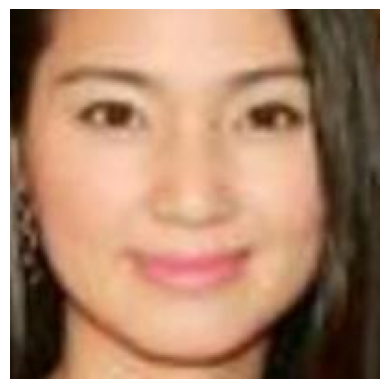

In [49]:
from PIL import Image
img = Image.open(df['image'][4710])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

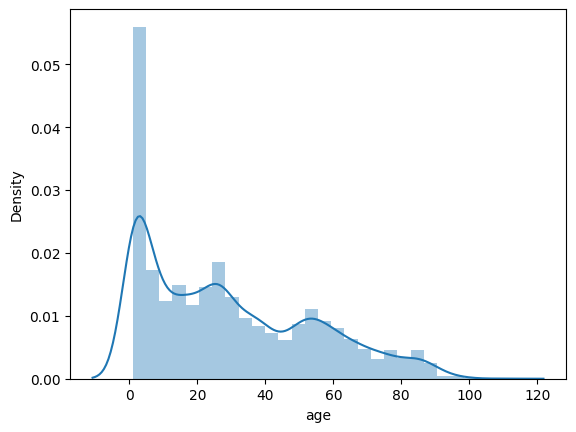

In [50]:
sns.distplot(df['age'])  # little right skewed

In [21]:
# df['age'].skew()
# log_age=np.log(df['age'])
# log_age.skew()
# sns.distplot(log_age)
# # original_age = np.exp(log_age)
# sns.distplot(log_age)
# # Sqrt Transform
# sqrt_age=np.sqrt(df['age'])
# sqrt_age.skew()
# sns.distplot(sqrt_age)

In [51]:
df['gender'].value_counts()

gender
1    5407
0    4372
Name: count, dtype: int64

In [52]:
df = df[df['gender'] != 3]

In [53]:
df['gender'].value_counts()

gender
1    5407
0    4372
Name: count, dtype: int64

In [54]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

<Axes: xlabel='gender', ylabel='count'>

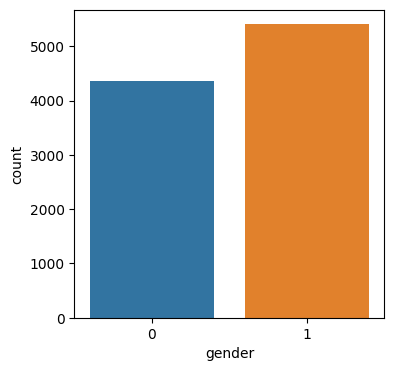

In [55]:
plt.figure(figsize=(4,4))
sns.countplot(x=df['gender'])

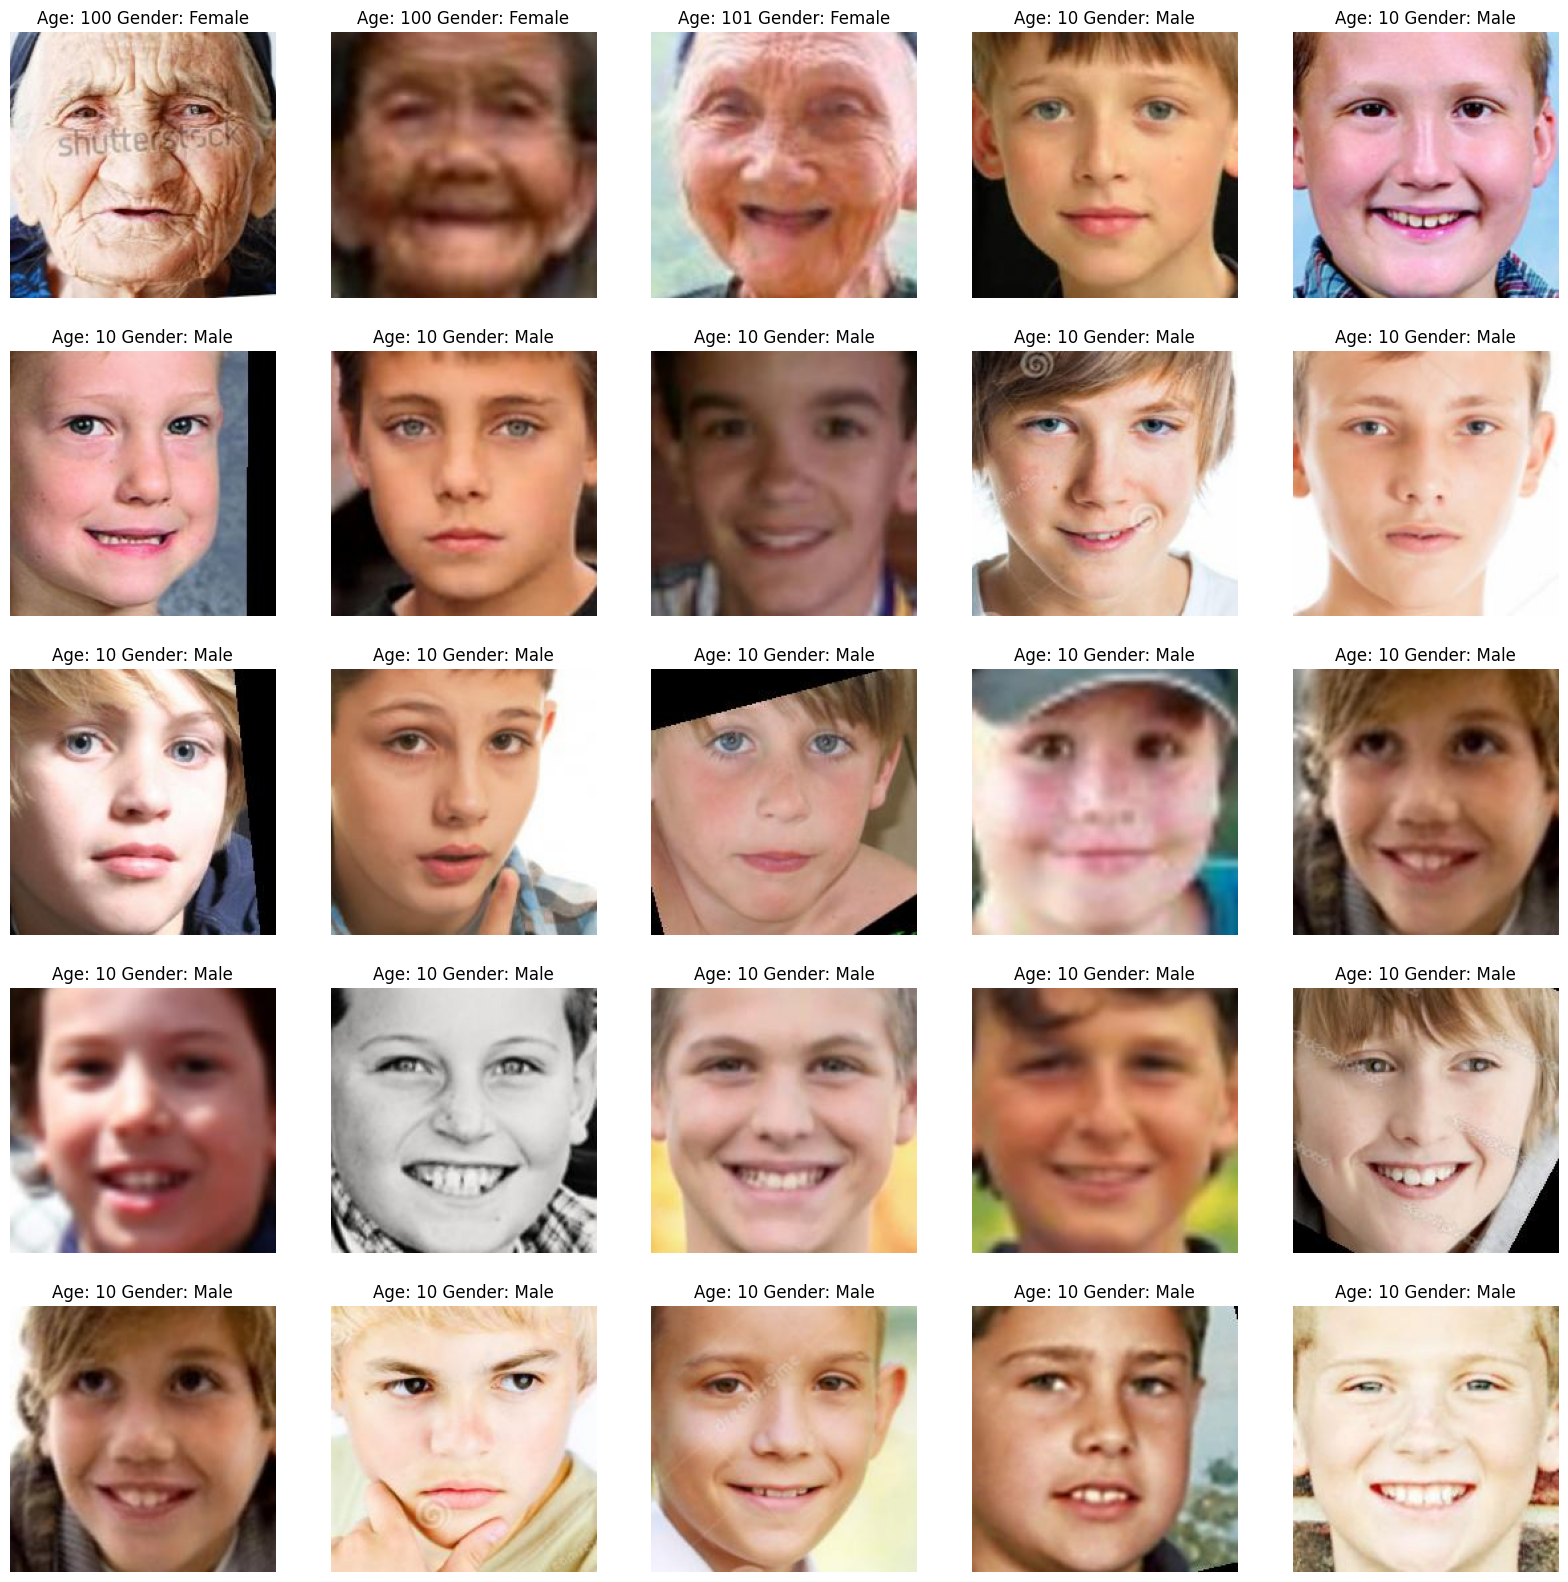

In [56]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = PIL.Image.open(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [57]:
def extract_features(images):
    features = []
    for image in tqdm(images):
#         img = PIL.Image.open(image,grayscale=True)
        img=load_img(image,grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [58]:
X = extract_features(df['image'])

  0%|          | 0/9779 [00:00<?, ?it/s]

In [59]:
X.shape

(9779, 128, 128, 1)

In [60]:
# normalize the images
# To do -> use mean standard deviation or something else
# X = X/255.0
def normalize_images(features):
    # Compute mean and standard deviation
    mean = np.mean(features)
    std = np.std(features)

    # Normalize features using mean and standard deviation
    normalized_features = (features - mean) / std

    return normalized_features

In [61]:
normalized_X = normalize_images(X)

In [62]:
normalized_X.shape

(9779, 128, 128, 1)

In [63]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

## Model Creation

In [64]:
# opt = SGD(lr=0.1, momentum=0.9)

In [65]:
def Model_Creation(input_shape):
    inputs = Input((input_shape))
    # convolutional layers
    conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
    maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
    conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
    maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
    conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
    maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
    conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
    maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

    flatten = Flatten() (maxp_4)

    # fully connected layers
    dense_1 = Dense(256, activation='relu') (flatten)
    dense_2 = Dense(256, activation='relu') (flatten)

    dropout_1 = Dropout(0.3) (dense_1)
    dropout_2 = Dropout(0.3) (dense_2)

    output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
    output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

    model = Model(inputs=[inputs], outputs=[output_1, output_2])

    model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

    return model

In [66]:
input_shape = (128, 128, 1)
model = Model_Creation(input_shape)

In [67]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

In [68]:
history = model.fit(x=normalized_X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.30)

Epoch 1/15
214/214 [==============================] - 183s 827ms/step - loss: 9.8732 - gender_out_loss: 0.6043 - age_out_loss: 9.2690 - gender_out_accuracy: 0.6717 - age_out_accuracy: 0.1015 - val_loss: 30.2788 - val_gender_out_loss: 0.5565 - val_age_out_loss: 29.7222 - val_gender_out_accuracy: 0.7212 - val_age_out_accuracy: 0.0000e+00
Epoch 2/15
214/214 [==============================] - 186s 869ms/step - loss: 7.6766 - gender_out_loss: 0.5271 - age_out_loss: 7.1495 - gender_out_accuracy: 0.7218 - age_out_accuracy: 0.1367 - val_loss: 29.6608 - val_gender_out_loss: 0.5394 - val_age_out_loss: 29.1214 - val_gender_out_accuracy: 0.7304 - val_age_out_accuracy: 0.0000e+00
Epoch 3/15
214/214 [==============================] - 217s 1s/step - loss: 6.6798 - gender_out_loss: 0.4823 - age_out_loss: 6.1975 - gender_out_accuracy: 0.7497 - age_out_accuracy: 0.1568 - val_loss: 26.9827 - val_gender_out_loss: 0.5092 - val_age_out_loss: 26.4736 - val_gender_out_accuracy: 0.7522 - val_age_out_accuracy: 

## Plot the result

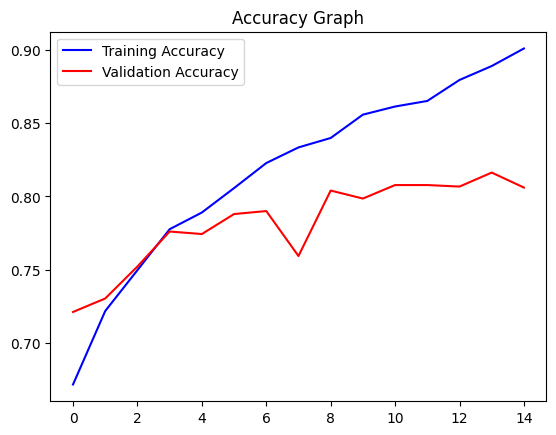

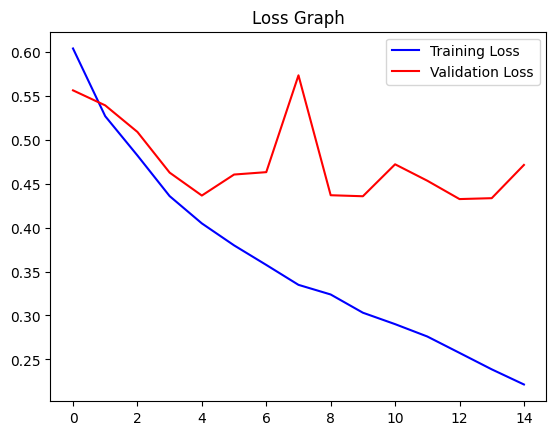

In [69]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

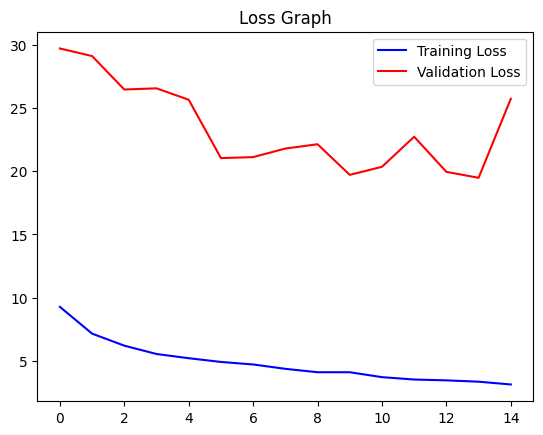

In [70]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [71]:
## Predictions with test data

In [72]:
def predictions(image_index):
    print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
    
    # predict from model
    pred = model.predict(X[image_index].reshape(1, 128, 128, 1))

    pred_gender = gender_dict[round(pred[0][0][0])]   #anything above 0.5 is 1 else 0.
    pred_age = round(pred[1][0][0])
    print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
    plt.axis('off')
    plt.imshow(X[image_index].reshape(128, 128,1), cmap='gray');

Original Gender: Female Original Age: 11
1/1 [==============================] - 0s 105ms/step
Predicted Gender: Male Predicted Age: 227


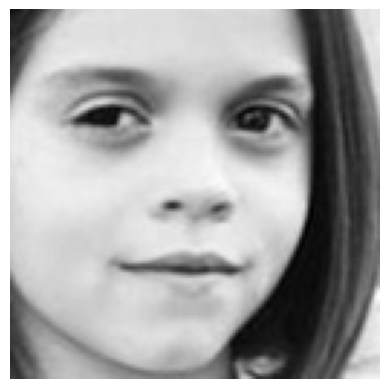

In [73]:
predictions(image_index=180)

Original Gender: Male Original Age: 38
1/1 [==============================] - 0s 61ms/step
Predicted Gender: Male Predicted Age: 83


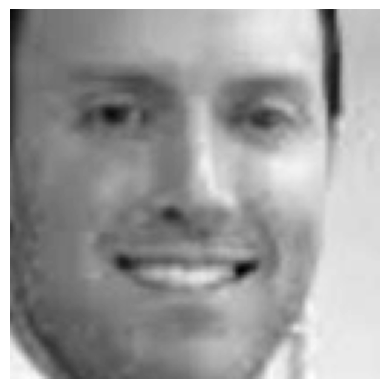

In [74]:
predictions(image_index=5150)

Original Gender: Female Original Age: 31
1/1 [==============================] - 0s 29ms/step
Predicted Gender: Female Predicted Age: 158


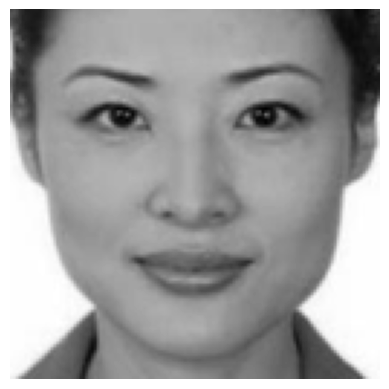

In [75]:
predictions(image_index=4500)

Original Gender: Male Original Age: 4
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Male Predicted Age: 13


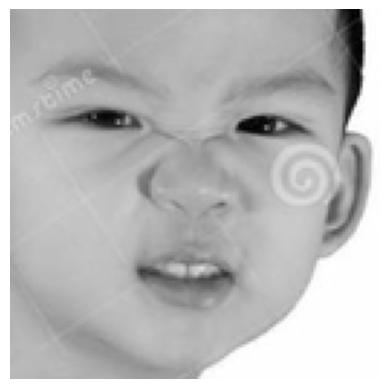

In [76]:
predictions(image_index=6399)